# Import libraries #

In [49]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.models import load_model
import cv2
import tensorflow as tf
import random
import matplotlib.patches as patches
from sklearn.preprocessing import LabelBinarizer

# Define metrics and loss function #

In [4]:
def iou(y_true, y_pred):
    y_true = K.reshape(y_true, [-1])
    y_pred = K.reshape(y_pred, [-1])
    y_true = tf.convert_to_tensor([y_true[0],y_true[1]-y_true[3],y_true[0]+y_true[2],y_true[1]])
    y_pred = tf.convert_to_tensor([y_pred[0],y_pred[1]-y_pred[3],y_pred[0]+y_pred[2],y_pred[1]])
    xl,yl = K.maximum(y_true[0],y_pred[0]), K.maximum(y_true[1],y_pred[1])
    xr,yr = K.minimum(y_true[2],y_pred[2]), K.minimum(y_true[3],y_pred[3])
    intersection = K.maximum(float(0),(xr-xl))*K.maximum(float(0),(yr-yl))
    union = ((y_true[2]-y_true[0])*(y_true[3]-y_true[1])) + ((y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1])) - intersection
    return intersection / union

def iou_loss(y_true, y_pred):
    return (1 - iou(y_true, y_pred))

def successful_prediction(y_true, y_pred):
    iou_score = iou(y_true, y_pred)
    return K.cast(iou_score > 0.5, dtype='float32')

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define data preprocess function #

In [6]:
def resize (data, IMAGE_SIZE):
    X=[]
    y=[]
    for i in range(len(data)):
        image = data[i]['image']
        resized_image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
        gray = cv2.cvtColor(np.array(resized_image), cv2.COLOR_RGB2GRAY)
        denoised = cv2.bilateralFilter(gray, 11, 17, 17)
        edged = cv2.Canny(denoised, 170, 200)
        edged = np.expand_dims(edged, axis=-1)
        X.append(edged)
        label = data[i]['objects']['bbox']
        label = [label[0][0]/data[i]['width'],label[0][1]/data[i]['height'],label[0][2]/data[i]['width'],label[0][3]/data[i]['height']]
        y.append(np.array(label))
    return np.array(X),np.array(y)

# Data preprocess #

In [7]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
testdata = ds['test']
IMAGE_SIZE = 224
x_test , y_test = resize(testdata,IMAGE_SIZE)
print('finish prepose')
x_test=x_test/255

finish prepose


# Load license plate detection model #

In [8]:
model = load_model('model/my_model_iou_250.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})

In [121]:
ran_num = random.randint(0,len(x_test))

# Vehicle license plate detect #

1/1 [==============================] - 0s 69ms/step
tf.Tensor(0.6480227650559526, shape=(), dtype=float64)
[0.37818834 0.47126576 0.22843668 0.10813563]
[264.0, 227.0, 83.0, 20.0]
178 142 107 32


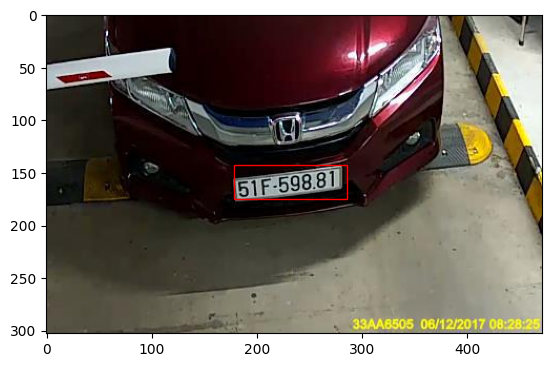

In [122]:
y = model.predict(x_test[ran_num:ran_num+1])[0]
y_test_double = tf.cast(y_test, tf.double)
y_double = tf.cast(y, tf.double)
print(iou(y_test_double[ran_num], y_double))
print(y)
print(testdata[0]['objects']['bbox'][0])
print(int(y[0]*testdata[ran_num]['width']), int(y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']))
fig, ax = plt.subplots(1)
ax.imshow(testdata[ran_num]['image'])
rect = patches.Rectangle((y[0]*testdata[ran_num]['width'], y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [11]:
print(testdata[ran_num])

{'image_id': 671, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303 at 0x1D2717E1C10>, 'width': 472, 'height': 303, 'objects': {'id': [682], 'area': [3201], 'bbox': [[126.0, 156.0, 97.0, 33.0]], 'category': [0]}}


# Crop license plate image #
bbox = (X1(The x of the upper left corner point),Y1(The y of the upper left corner point),X2(The x of the lower right corner point),Y2(The y of the lower right corner point))

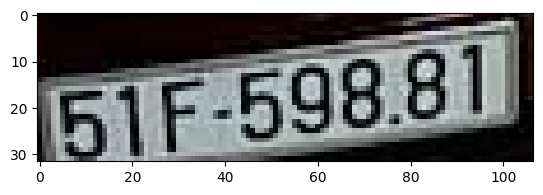

In [123]:
bbox = (int(y[0]*testdata[ran_num]['width']),int(y[1]*testdata[ran_num]['height']),int(y[0]*testdata[ran_num]['width'])+int((y[2])*testdata[ran_num]['width']),int(y[1]*testdata[ran_num]['height'])+int((y[3])*testdata[ran_num]['height']))
cropped_image = testdata[ran_num]['image'].crop(bbox)
plt.imshow(cropped_image)
plt.show()
cropped_image = np.array(cropped_image)

# Character segmentation #
First resize the cropped image to 270x90 pixels to facilitate segmentation.<br>
Convert the resized image to a binary image. Pixels with a value greater than 130 are set to 0 (black), and pixels with a value less than or equal to 130 are set to 255 (white).<br>
Finding external contours in binary images.</br>
For each contour, it calculates the bounding rectangle, extracts the corresponding character from the grayscale image, and appends a tuple of the y-coordinate, x-coordinate, and character image to the bounding_rects_and_chars list, but only if the width and height of the bounding rectangle are both greater than 10.</br>
Sort the bounding rectangle and character list first by y-coordinate (divided by a threshold so characters close to y-coordinate end up in the same group), then by x-coordinate. This produces a list sorted from top to bottom and left to right within each row.</br>
Create a new list containing only the character images in sorted order.

In [138]:
threshold = 50
img_lp = cv2.resize(cropped_image, (270, 90))
gray = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_rects_and_chars = []
print(len(contours))
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 10 and h > 10:
        char_img = np.array(gray[y:y+h, x:x+w])
        bounding_rects_and_chars.append((y, x, char_img))
bounding_rects_and_chars.sort(key=lambda x: (x[0] // threshold, x[1]))
char = [char_img for y, x, char_img in bounding_rects_and_chars]
char.pop(0)

11


array([[ 1,  1,  1, ..., 31, 30, 30],
       [ 1,  1,  1, ..., 30, 30, 30],
       [ 1,  1,  1, ..., 26, 28, 28],
       ...,
       [ 5,  9, 26, ...,  2,  1,  1],
       [ 4,  8, 23, ...,  0,  0,  0],
       [ 4,  7, 23, ...,  0,  0,  0]], dtype=uint8)

# Show each character #

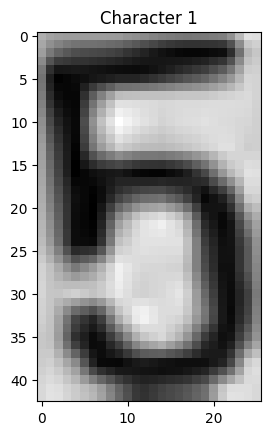

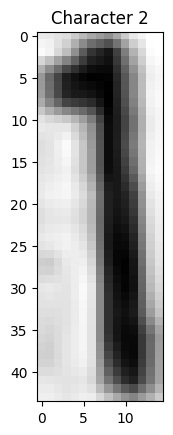

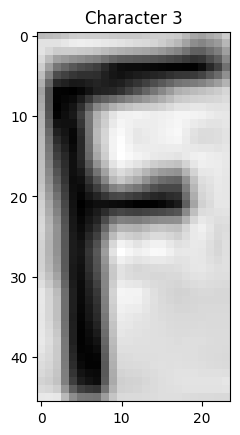

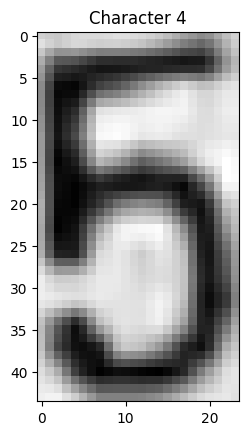

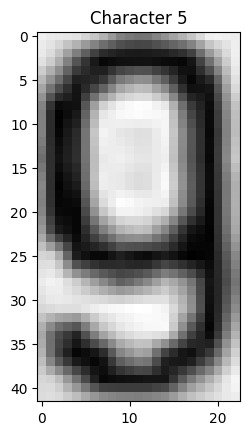

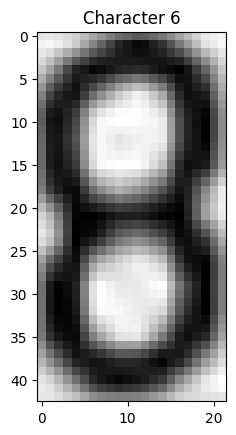

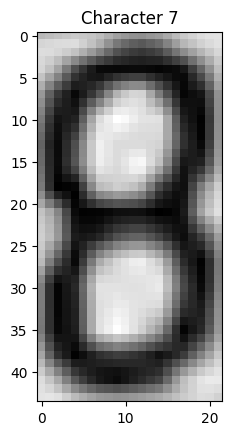

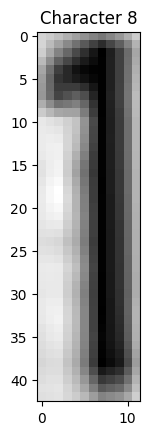

In [139]:
for i, character in enumerate(char):
    plt.figure()
    plt.imshow(character, cmap='gray')
    plt.title('Character ' + str(i+1))
    plt.show()

# Load character recognition model #

In [84]:
model_cr = load_model('model/my_model_cr.h5')

In [52]:
classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z']
lb = LabelBinarizer()
one_hot_labels = lb.fit_transform(classes)

# Recognize every character #

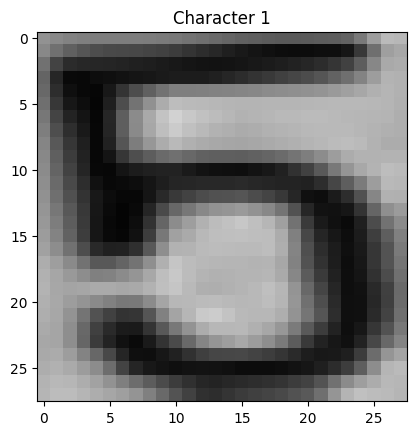

1/1 [==============================] - 0s 34ms/step
1.0
Character 1: 5


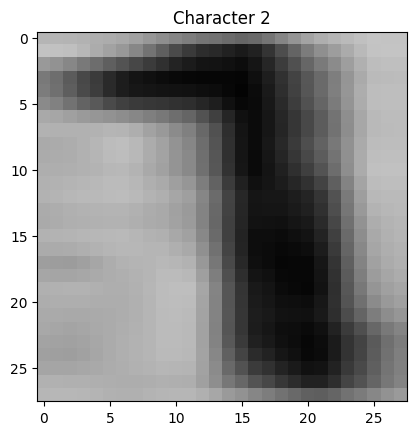

1/1 [==============================] - 0s 36ms/step
0.9955901
Character 2: 1


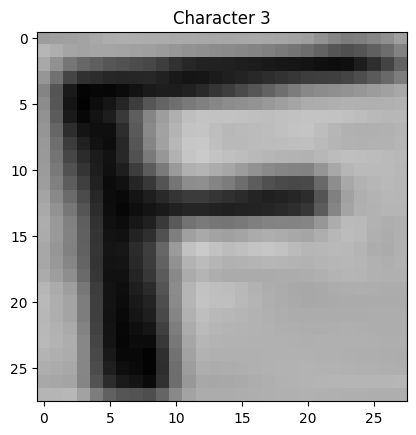

1/1 [==============================] - 0s 34ms/step
1.0
Character 3: F


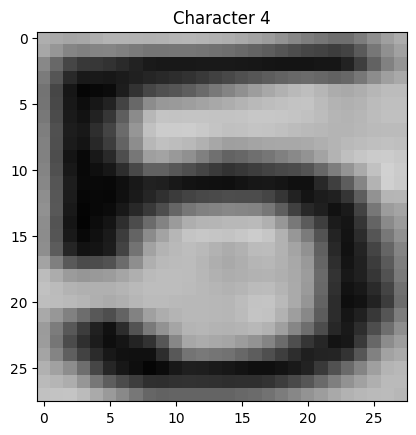

1/1 [==============================] - 0s 33ms/step
1.0
Character 4: 5


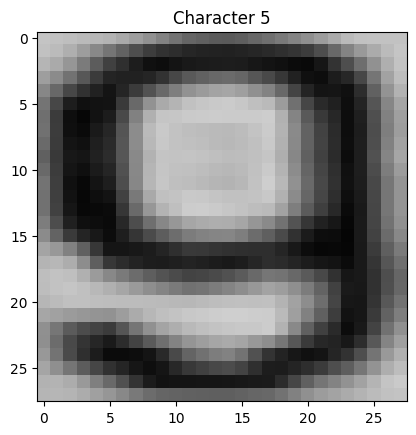

1/1 [==============================] - 0s 32ms/step
0.99975413
Character 5: 9


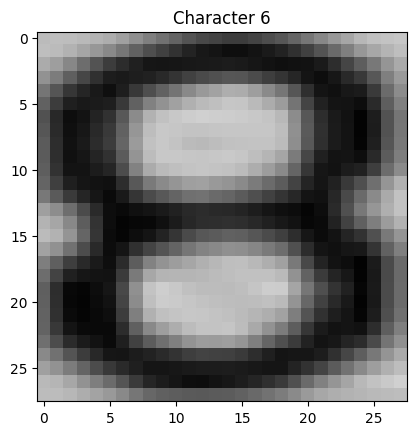

1/1 [==============================] - 0s 44ms/step
1.0
Character 6: 8


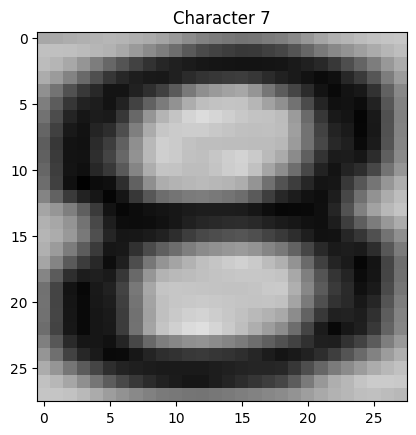

1/1 [==============================] - 0s 30ms/step
1.0
Character 7: 8


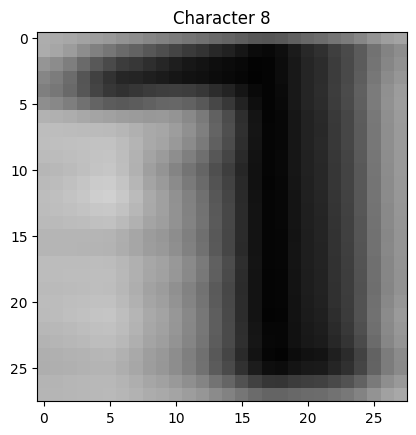

1/1 [==============================] - 0s 43ms/step
0.99945647
Character 8: 1


In [142]:
license_plate_number = ''
for i, character in enumerate(char):
    character = cv2.resize(character,(28, 28), interpolation=cv2.INTER_CUBIC)
    character = cv2.cvtColor(character, cv2.COLOR_GRAY2RGB)
    #character = cv2.bitwise_not(character)
    plt.figure()
    plt.imshow(character, cmap='gray')
    plt.title('Character ' + str(i+1))
    plt.show()
    character = character.astype('float32') / 255
    character = np.expand_dims(character, axis=0)
    #character = np.expand_dims(character, axis=-1)
    y_char = model_cr.predict(character)
    y_char_one_hot = np.argmax(y_char, axis=-1)
    print(np.max(y_char))
    if np.max(y_char) > 0.9:
        print('Character {}: {}'.format(i+1, classes[y_char_one_hot[0]]))
        license_plate_number = license_plate_number + classes[y_char_one_hot[0]]

# Print license plate number #

In [144]:
print('License plate number:',license_plate_number)

License plate number: 51F59881
